# Machine Learning - Examinering
#### Charlie Rosander




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score

 ### In this notebook we will do some EDA/ETL, preprocessing of the data, and then train a model and see what we can do with it.
 We will be using the Happiness dataset from kaggle, and try to predict the happiness score of a country based on the other features in the dataset.
 (https://www.kaggle.com/datasets/sougatapramanick/happiness-index-2018-2019)

Some of the steps we might take are:

- EDA
    - Visualizations
    - Correlations
<br>
<br>
- Preprocessing
    - Missing values
    - Outliers
    - Scaling
    - Encoding
    - Train test split
<br>
<br>
- Model
    - Train
    - Evaluate
    - Predict
<br>
<br>
- Evaluation
    - Metrics
    - Visualizations
<br>
<br>
- Conclusion
    - What did we learn?
    - What could we have done better?
    - What could we do next?

    

In [2]:
# We start by loading the data from the csv file
data_2018 = pd.read_csv('./data/happiness/2018.csv')
data_2019 = pd.read_csv('./data/happiness/2019.csv')


In [3]:
# Inspect the data.
# We see that we have a column containing the country name or region, and as they are letters we might need to encode them later on.
# We also see that the dataset doesn't really need any comprehensive cleaning aside from.
data_2018

# We start by creating a copy of the data, so we can modify it without losing the original data.
data_2018_copy = data_2018.copy()
data_2019_copy = data_2019.copy()

### To more easily understand the dataset and its features I will put the description of the data here:

### Overview of the Data (2018 & 2019)

- Overall rank: List of ranks of different countries from 1 to 156
- Country or region: List of the names of different countries.
- Score: List of happiness scores of different countries.
- GDP per capita: The GDP per capita score of different countries.
- Social support: The social support of different countries.
- Healthy life expectancy: The healthy life expectancy of different countries.
- Freedom to make life choices: The score of perception of freedom of different countries.
- Generosity: Generosity (the quality of being kind and generous) score of different countries.
- Perceptions of corruption: The score of the perception of corruption in different countries.

In [4]:
# We use the describe function to get a quick overview of the data.
data_2018.describe()

,Overall rank,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,78.500000,5.375917,0.891449,1.213237,0.597346,0.454506,0.181006,0.112449
std,45.177428,1.119506,0.391921,0.302372,0.247579,0.162424,0.098471,0.096343
min,1.000000,2.905000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,39.750000,4.453750,0.616250,1.066750,0.422250,0.356000,0.109500,0.051000
50%,78.500000,5.378000,0.949500,1.255000,0.644000,0.487000,0.174000,0.082000
75%,117.250000,6.168500,1.197750,1.463000,0.777250,0.578500,0.239000,0.139000
max,156.000000,7.632000,2.096000,1.644000,1.030000,0.724000,0.598000,0.457000


In [5]:
# Quick check for nan values, there are none.
data_2018.isnull().sum()

Overall rank                    0
Country or region               0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

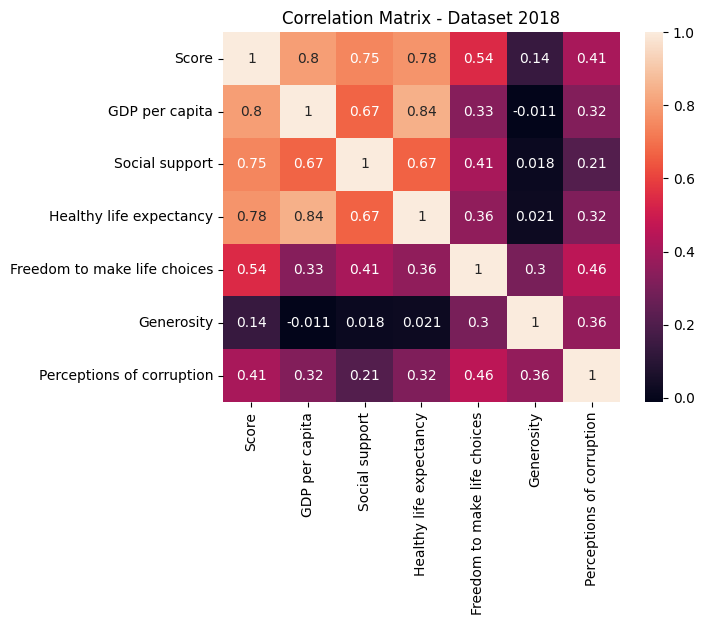

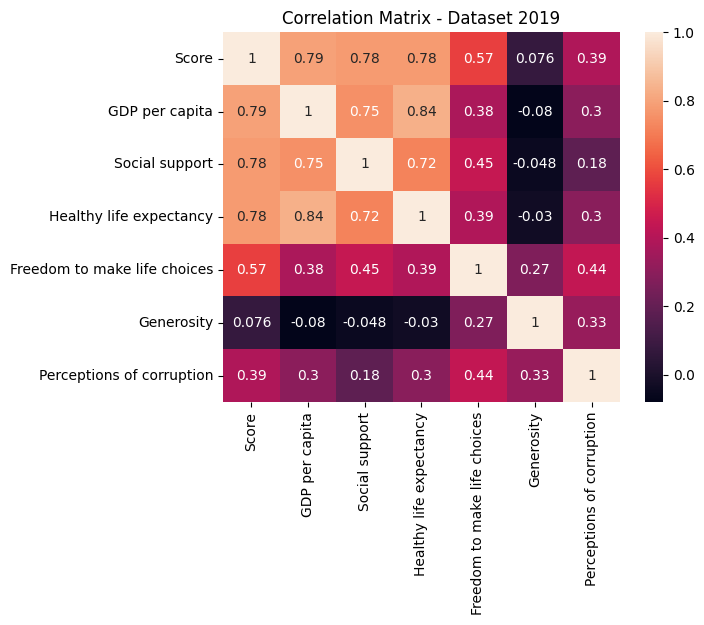

In [6]:
# Here we check the correlation between the different columns, but for this I will drop the country name column.
# We will be using a heatmap to visualize the correlation.

# We drop the country name column.
data_2018_copy.drop(['Country or region'], axis=1, inplace=True)

# As well as the Overall rank column, as it doesn't really tell us anything here.
data_2018_copy.drop(['Overall rank'], axis=1, inplace=True)

# We create a correlation matrix.
corr_2018 = data_2018_copy.corr(method="pearson")

# We create a heatmap to visualize the correlation.
sns.heatmap(corr_2018, annot=True)
plt.title('Correlation Matrix - Dataset 2018')
plt.show()

# We will also quickly examine the dataset from 2019, to see if there are any major differences.
data_2019 = pd.read_csv('./data/happiness/2019.csv')

data_2019_copy.drop(['Country or region'], axis=1, inplace=True)

data_2019_copy.drop(['Overall rank'], axis=1, inplace=True)

corr_2019 = data_2019_copy.corr(method="pearson")

sns.heatmap(corr_2019, annot=True)
plt.title('Correlation Matrix - Dataset 2019')
plt.show()


From this we can see that there is a strong correlation between:
- GDP per capita and score
- Social support and score
- Healthy life expectancy and score

As well as:
- GDP per capita and social support
- GDP per capita and healthy life expectancy
- Social support and healthy life expectancy
- Social support and healy life expectancy

Which is both interesting and expected as people who live in countries with a high GDP per capita, social support and healthy life expectancy are more likely to be happy, and that a higher social support leads to a higher healthy life expectancy. 


We can also see that there is a weak correlation between:
- Freedom to make life choices and score
- Generosity and score
- Perceptions of corruption and score

This is also quite interesting as this tells me that for example the freedom to make life choices is not as important as the other features when it comes to happiness, the correlation is quite low.

Generosity is even more interesting as the correlation there is almost non-existant, which at first thought would seem strange as you would think that countries who are more generous would have a happier population, but judging from this dataset that is not necessarily the case, which is something to think about. 

Let's start testing  different models by trying to predict the happiness score of a country based on some of the more interesting features in the dataset.

We have chosen to use the following features based on the correlations we found above:
- GDP per capita
- Social support
- Healthy life expectancy
- Freedom to make life choices
- Generosity
- Perceptions of corruption

### Creating, training and testing the models

We will create and train the models in order, using GridSearchCV where possible to find the best parameters for each model.

We will then test the models and see how they perform, using different scoring methods, as well as plotting the results so we can see how they compare.

In [7]:
# Here we create lists to store the different results from the models to easily compare them later on.
# We will also scale the data in the data_2018_copy dataframe.
model_results = {}


**Linear Regression**

In [8]:
# Select the features and target variable
features = ['GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices',
            'Generosity', 'Perceptions of corruption']
target = 'Score'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_2018[features], data_2018[target], test_size=0.2, random_state=42)

# We will now scale the data.
# We will scale the data using the MinMaxScaler, as we want to keep the data in the range of 0-1.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the linear regression model
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = reg_model.predict(X_test)



**Testing of the LinearRegression model**

- MSE - Mean squared error, the lower the better
- R2 - R squared, the higher the better
- CV - Cross validation (K-fold), the higher the better
- Plotting - Plotting the predicted values against the actual values, the closer to a straight line the better

Mean Squared Error: 0.31697444573692424
R2 Score: 0.6939247547569343
Cross-Validation Scores: [0.79894462 0.81700756 0.67780112 0.84494538 0.71931745]
Average cross-validation score: 0.77


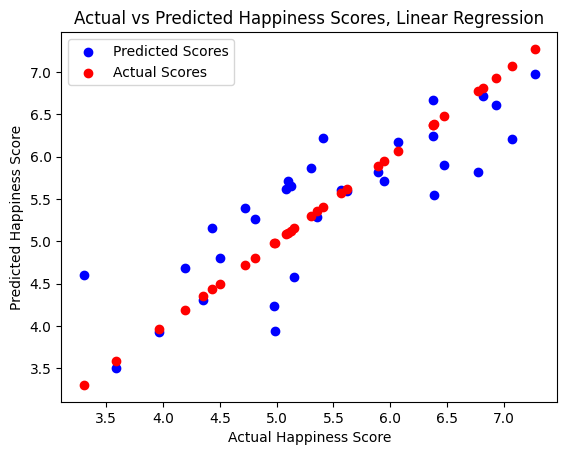

In [9]:
# Test the models accuracy with different methods.
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

cv_scores = cross_val_score(reg_model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average cross-validation score: {:.2f}".format(cv_scores.mean()))

# We plot the actual vs predicted happiness scores to visualize the results.
plt.scatter(y_test, y_pred, color='blue', label='Predicted Scores')
plt.scatter(y_test, y_test, color='red', label='Actual Scores')
plt.xlabel('Actual Happiness Score')
plt.ylabel('Predicted Happiness Score')
plt.title('Actual vs Predicted Happiness Scores, Linear Regression')
plt.legend()
plt.show()

# We add the results to the list.
model_results['Linear Regression'] = {
    'MSE': mse, 
    'R2': r2, 
    'CV Scores': cv_scores.mean()
    }

We can see the scores of the regression model is okay, but we will see if we can get better scores with other models.

### These are the models we will be testing next:
- Random Forest
- Decision Tree
- KNN
- Stacking

**Random Forest**

GridSearchCV

In [10]:
# We will use GridSearchCV to find the best parameters for the model.

# Define the parameter grid
params_rf = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=3000, num=20)]}

# Create a base model
rf = RandomForestRegressor(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=params_rf, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# THIS CODE TAKES TOO LONG

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'n_estimators': 1168}


Training of the Random Forest model

In [11]:
# Extract the best parameters
best_params_rf = grid_search.best_params_

# We will now use the best parameters to create a new model.
rf_model = RandomForestRegressor(n_estimators=best_params_rf["n_estimators"], random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1168, random_state=42)

**Testing of the RandomForest model**
- MSE - Mean squared error, the lower the better
- R2 - R squared, the higher the better
- CV - Cross validation (K-fold), the higher the better
- Plotting - Plotting the predicted values against the actual values, the closer to a straight line the better
- Feature importance - Plotting the feature importance of the model

Mean Squared Error: 0.3424088726856134
R^2 Score: 0.6693648933212968
Cross-Validation Scores: [0.83592167 0.76791964 0.7895099  0.81355617 0.73599678]
Average Cross-Validation Score: 0.79


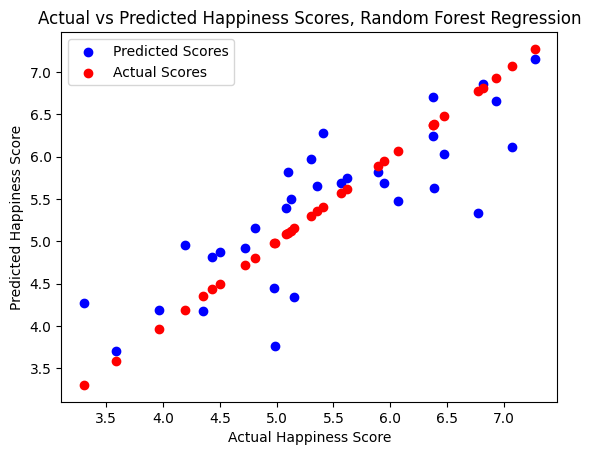

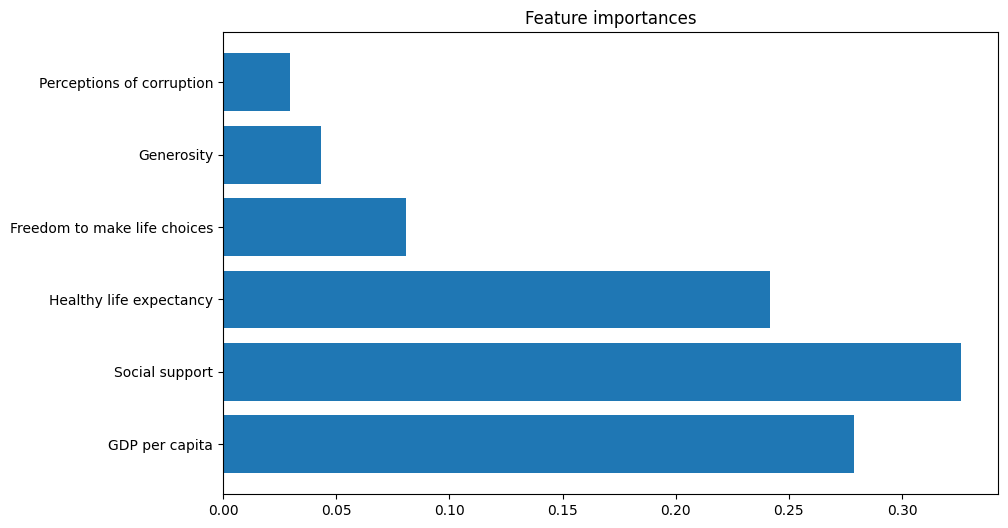

In [12]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# Perform cross-validation and calculate the average score
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score: {:.2f}".format(cv_scores.mean()))

# We plot the actual vs predicted happiness scores to visualize the results.
plt.scatter(y_test, y_pred, color='blue', label='Predicted Scores')
plt.scatter(y_test, y_test, color='red', label='Actual Scores')
plt.xlabel('Actual Happiness Score')
plt.ylabel('Predicted Happiness Score')
plt.title('Actual vs Predicted Happiness Scores, Random Forest Regression')
plt.legend()
plt.show()

# Get the feature importances
importances = rf_model.feature_importances_

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances, align='center')
plt.yticks(range(X_train.shape[1]), features)
plt.show()

# We add the results to the list.
model_results["Random Forest"] = {
    "MSE": mse,
    "R2": r2,
    "CV Scores": cv_scores.mean(),
}

From the testing of the RandomForest model we can see that it performs better than the LinearRegression model.
It's also interesting to see the feature importance of the model, as we can see and compare with what we saw in the correlation matrix, that GDP per capita, social support and healthy life expectancy are the most important features when it comes to predicting the happiness score of a country. 

However, from this models testing we see that social support is the most important feature, which is interesting as we saw in the correlation matrix that GDP per capita was the most important feature for 2018.

**Decision Tree**

GridSearchCV

In [13]:
# We will now use a Decision Tree Regressor model.
# We will once again use GridSearch to find the best parameters for the model.

# Define the parameters to tune
params_dt = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

# Initialize the Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42)

# Initialize the GridSearchCV
grid_search = GridSearchCV(tree_model, params_dt, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
print('Best parameters:', grid_search.best_params_)


Best parameters: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 9}


Training of the DecisionTree model

In [14]:
# Extract the best parameters
best_params_dt = grid_search.best_params_

# We will now use the best parameters to create a new model.
tree_model = DecisionTreeRegressor(max_depth=best_params_dt['max_depth'], 
                                   min_samples_leaf=best_params_dt['min_samples_leaf'], 
                                   min_samples_split=best_params_dt['min_samples_split'], 
                                   random_state=42)

# Fit the model to the training data
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=2, min_samples_split=9,
                      random_state=42)

**Testing of the DecisionTree model**
- MSE - Mean squared error, the lower the better
- R2 - R squared, the higher the better
- CV - Cross validation (K-fold), the higher the better
- Plotting - Plotting the predicted values against the actual values, the closer to a straight line the better

Mean Squared Error: 0.4454991905143209
R^2 Score: 0.5698193471866557
Cross-Validation Scores: [0.7662878  0.74636899 0.47906412 0.81294959 0.67664841]
Average cross-validation score: 0.70


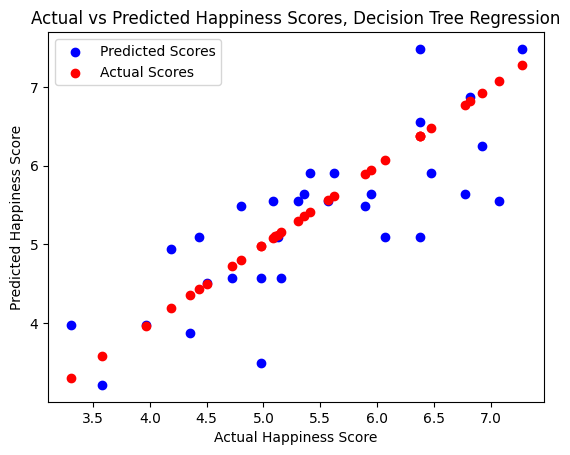

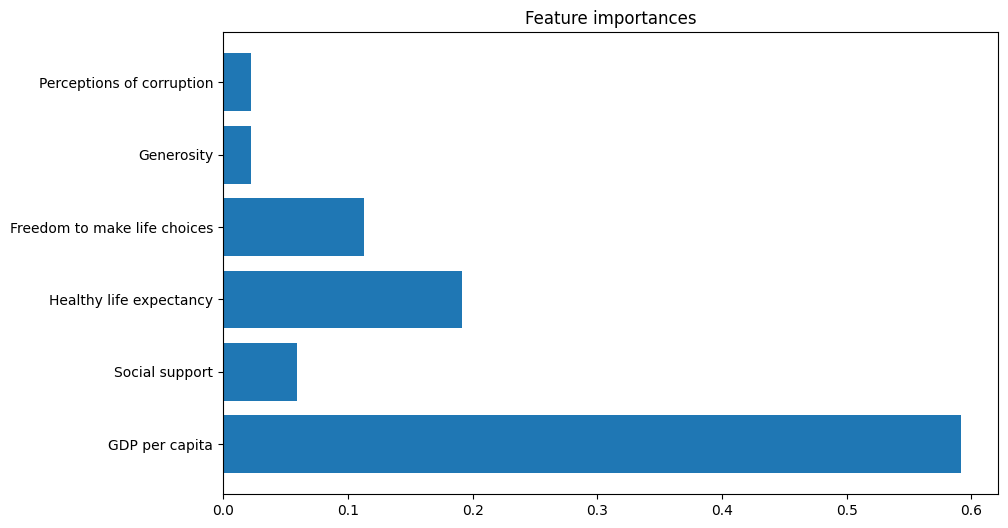

In [15]:
# Make predictions
y_pred = tree_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# Perform cross-validation and calculate the average score
cv_scores = cross_val_score(tree_model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average cross-validation score: {:.2f}".format(cv_scores.mean()))

plt.scatter(y_test, y_pred, color='blue', label='Predicted Scores')
plt.scatter(y_test, y_test, color='red', label='Actual Scores')
plt.xlabel('Actual Happiness Score')
plt.ylabel('Predicted Happiness Score')
plt.title('Actual vs Predicted Happiness Scores, Decision Tree Regression')
plt.legend()
plt.show()

# Get the feature importances
importances = tree_model.feature_importances_

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances, align='center') 
plt.yticks(range(X_train.shape[1]), features) 
plt.show()

# We add the results to the list.
model_results["Decision Tree"] = {
    "MSE": mse,
    "R2": r2,
    "CV Scores": cv_scores.mean(),
}

We can see that the DecisionTree model performs worse than both of the other models, but also how the feature-importance differs from the RandomForest model, as we can see that the most important feature is GDP per capita by a big margin, and that Freedom to make life choices makes a comeback as the third most important feature.

**KNN**

GridSearchCV

In [16]:
# We will now use KNN regression.
# We will once again use GridSearch to find the best parameters for the model.

# Define the parameters
params_knn = {
    'n_neighbors': range(1, 21), # Number of neighbors to use
    'weights': ['uniform', 'distance'], # Uniform weights or distance weights
    'p': [1, 2] # 1: Manhattan distance, 2: Euclidean distance
}

# Initialize the KNN Regressor
knn_model = KNeighborsRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_model, params_knn, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
print('Best parameters:', grid_search.best_params_)


Best parameters: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}


Training of the KNN model

In [17]:
# We will now use the best parameters to create a new model.
# Extract best parameters
best_params_knn = grid_search.best_params_

# Create a new KNN Regressor with best parameters
knn_model_best = KNeighborsRegressor(n_neighbors=best_params_knn["n_neighbors"], 
                                     weights=best_params_knn["weights"], 
                                     p=best_params_knn["p"])

# Fit the model
knn_model_best.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=8, p=1, weights='distance')

**Testing of the KNN model**

Mean Squared Error: 0.4153744476937878
R^2 Score: 0.5989082474771591
Cross-Validation Scores: [0.78796234 0.78658408 0.76514441 0.84795019 0.74263059]
Average cross-validation score: 0.79


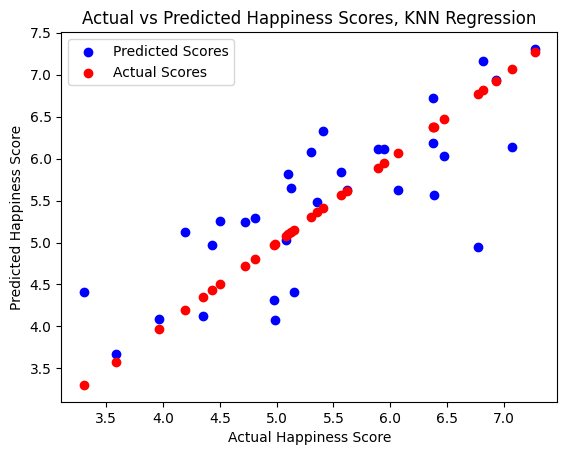

In [18]:
# Predict
y_pred = knn_model_best.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# Perform cross-validation and calculate the average score
cv_scores = cross_val_score(knn_model_best, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average cross-validation score: {:.2f}".format(cv_scores.mean()))

# Plot the predicted vs actual happiness scores
plt.scatter(y_test, y_pred, color='blue', label='Predicted Scores')
plt.scatter(y_test, y_test, color='red', label='Actual Scores')
plt.xlabel('Actual Happiness Score')
plt.ylabel('Predicted Happiness Score')
plt.title('Actual vs Predicted Happiness Scores, KNN Regression')
plt.legend()
plt.show()

# We add the results to the list.
model_results["KNN"] = {
    "MSE": mse,
    "R2": r2,
    "CV Scores": cv_scores.mean(),
}

We can see here that KNN performed pretty well.

Last but not least we will try to stack the models and see if we can get even better results.

**Stacking**

Mean Squared Error: 0.4050300740452213
R^2 Score: 0.6088969287224564
Cross-Validation Scores: [0.80413505 0.79705222 0.80498109 0.8598836  0.75040163]
Average cross-validation score: 0.80


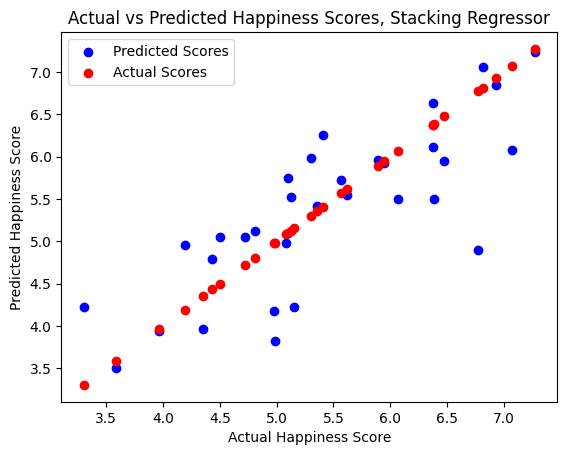

In [19]:
# We will now use stacking to combine the models and see if we can improve the results.
# We will use the best parameters for each model.

# Define the base models; Random Forest, Decision Tree and KNN
base_models = [
    ('random_forest', RandomForestRegressor(n_estimators=best_params_rf["n_estimators"], 
                                            random_state=42)),

    ('decision_tree', DecisionTreeRegressor(max_depth=best_params_dt["max_depth"], 
                                            min_samples_split=best_params_dt["min_samples_split"], 
                                            min_samples_leaf=best_params_dt["min_samples_leaf"], 
                                            random_state=42)),

    ('knn', KNeighborsRegressor(n_neighbors=best_params_knn["n_neighbors"], 
                                     weights=best_params_knn["weights"], 
                                     p=best_params_knn["p"]))
]

# Initialize the stacking model
stacking_model = StackingRegressor(estimators=base_models, 
                                   final_estimator=LinearRegression(), 
                                   cv=3)

# Fit the model
stacking_model.fit(X_train, y_train)

# Predict
y_pred = stacking_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# Perform cross-validation and calculate the average score
cv_scores = cross_val_score(stacking_model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average cross-validation score: {:.2f}".format(cv_scores.mean()))

# Plot the predicted vs actual happiness scores
plt.scatter(y_test, y_pred, color='blue', label='Predicted Scores')
plt.scatter(y_test, y_test, color='red', label='Actual Scores')
plt.xlabel('Actual Happiness Score')
plt.ylabel('Predicted Happiness Score')
plt.title('Actual vs Predicted Happiness Scores, Stacking Regressor')
plt.legend()
plt.show()

# We add the results to the list.
model_results["Stacking"] = {
    "MSE": mse,
    "R2": r2,
    "CV Scores": cv_scores.mean(),
}

# THIS CODE TAKES TOO LONG

In [20]:
# Here we will use the results from the model_results to create a dataframe.

# Create a dataframe with the results
df_results = pd.DataFrame(model_results).T
df_results['Model'] = df_results.index
df_results.reset_index(drop=True, inplace=True)
# Reorder the columns
df_results = df_results[['Model', 'MSE', 'R2', 'CV Scores']]

## Model results

In [21]:
# Print the dataframe, sorted by the CV Scores
df_results.sort_values(by='CV Scores', ascending=False)

,Model,MSE,R2,CV Scores
4,Stacking,0.405030,0.608897,0.803291
1,Random Forest,0.342409,0.669365,0.788581
3,KNN,0.415374,0.598908,0.786054
0,Linear Regression,0.316974,0.693925,0.771603
2,Decision Tree,0.445499,0.569819,0.696264


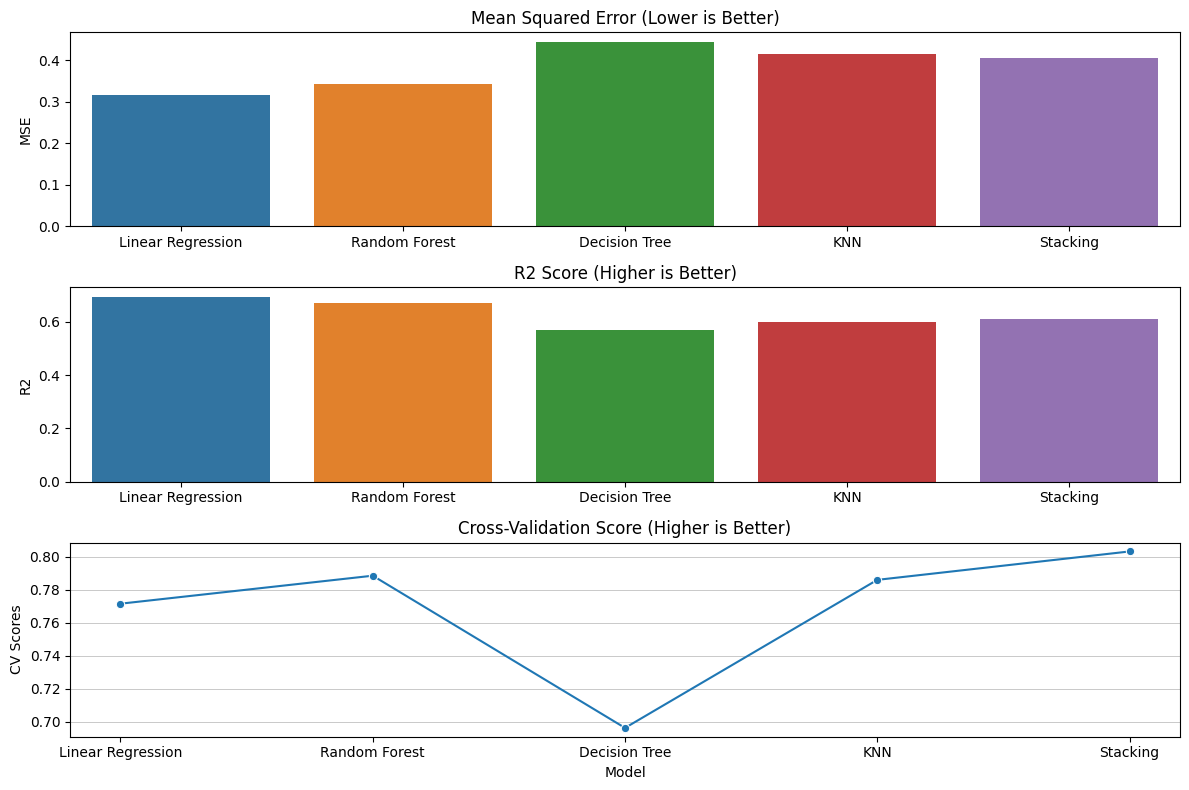

In [22]:
# Plot the CV Scores for each model to compare them in a line chart.
df_results['MSE'] = df_results['MSE'].astype(float)
df_results['R2'] = df_results['R2'].astype(float)
df_results['CV Scores'] = df_results['CV Scores'].astype(float)

plt.figure(figsize=(12, 8))

# MSE plot
plt.subplot(3, 1, 1)
sns.barplot(x='Model', y='MSE', data=df_results)
plt.title('Mean Squared Error (Lower is Better)')
plt.xlabel('')

# R2 plot
plt.subplot(3, 1, 2)
sns.barplot(x='Model', y='R2', data=df_results)
plt.title('R2 Score (Higher is Better)')
plt.xlabel('')

# CV Scores plot
plt.subplot(3, 1, 3)
sns.lineplot(x='Model', y='CV Scores', data=df_results, sort=False, marker='o')
plt.title('Cross-Validation Score (Higher is Better)')
plt.grid(True, which="both", ls="-", linewidth=0.5, color='0.7', axis='y')  # Add horizontal gridlines

plt.tight_layout()
plt.show()

As we can see from the results, on average the Stacking model and Random Forest performed the best.

I read that there is a way to measure the feature-importances of Linear regression, but it wasn't as clear-cut as for the other models so I decided to leave it out.

*"the interpretation of feature importance in a linear regression model assumes that the relationship between each feature and the output variable is linear and that the features are independent of each other. If these assumptions are violated, the feature importances may not be accurate or meaningful."*

Now I want to perform a little experiment, introducing a new "Testland" with random values within the range of the dataset, and see how the models perform on that.

In [37]:
# Define a list of features
features = ['GDP per capita', 'Social support', 'Healthy life expectancy', 
            'Freedom to make life choices', 'Generosity', 'Perceptions of corruption']

# Initialize an empty dictionary to store the min and max values
feature_ranges = {}

# Loop through each feature and find the min and max values so we can randomize in that range for the dummy data.
for feature in features:
    feature_min = data_2018[feature].min()
    feature_max = data_2018[feature].max()
    
    # Store the min and max values in the dictionary
    feature_ranges[feature] = (feature_min, feature_max)

# Create the dummy data for each feature.
np.random.seed()
dummy_data = pd.DataFrame({
    'GDP per capita': [np.random.uniform(feature_ranges['GDP per capita'][0], feature_ranges['GDP per capita'][1])],
    'Social support': [np.random.uniform(feature_ranges['Social support'][0], feature_ranges['Social support'][1])],
    'Healthy life expectancy': [np.random.uniform(feature_ranges['Healthy life expectancy'][0], feature_ranges['Healthy life expectancy'][1])],
    'Freedom to make life choices': [np.random.uniform(feature_ranges['Freedom to make life choices'][0], feature_ranges['Freedom to make life choices'][1])],
    'Generosity': [np.random.uniform(feature_ranges['Generosity'][0], feature_ranges['Generosity'][1])],
    'Perceptions of corruption': [np.random.uniform(feature_ranges['Perceptions of corruption'][0], feature_ranges['Perceptions of corruption'][1])]
})

# Predict the happiness score for "Testland" using the stacking model
pred_score_stacking = stacking_model.predict(dummy_data.values)[0]
print("Predicted score for Testland:", pred_score_stacking)

# Add the predicted score to the "Testland" dataframe
dummy_data['Score'] = pred_score_stacking

# Create a dataframe for "Testland"
df_testland = pd.DataFrame(dummy_data.loc[0]).rename(columns={0: 'Testland'})

# Find a country with a similar score to the predicted score for "Testland"
comparison_country = data_2018.iloc[(data_2018['Score'] - pred_score_stacking).abs().argsort()[:1]]

# Create a dataframe for the comparison country
df_comparison_country = comparison_country.T
df_comparison_country.columns = [comparison_country['Country or region'].values[0]]

# Drop the unnecessary columns
# comparison_country = comparison_country.drop(columns=['Overall rank', 'Country or region'])

# Concatenate the dataframes for comparison
comparison_df = pd.concat([df_testland, df_comparison_country], axis=1)
comparison_df = comparison_df.drop(['Overall rank', 'Country or region'], axis=0)

comparison_df

Predicted score for Testland: 4.666359059757337


,Testland,Ivory Coast
GDP per capita,0.402245,0.541
Social support,0.371299,0.872
Healthy life expectancy,0.497296,0.08
Freedom to make life choices,0.354203,0.467
Generosity,0.540846,0.146
Perceptions of corruption,0.001553,0.103
Score,4.666359,4.671


In [1]:
# Transpose the dataframe so that the features become rows and the countries become columns
comparison_df_T = comparison_df.T

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar plot
comparison_df_T.plot(kind='bar', ax=ax)

# Set the title and labels
ax.set_title('Comparison between Testland and Similar Country')
ax.set_xlabel('Features')
ax.set_ylabel('Values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Display the plot
plt.show()

NameError: name 'comparison_df' is not defined